<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center> Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 4.  Сравнение алгоритмов классификации

Теперь мы наконец подойдем к обучению моделей классификации, сравним на кросс-валидации несколько алгоритмов, разберемся, какие параметры длины сессии (*session_length* и *window_size*) лучше использовать. Также для выбранного алгоритма построим кривые валидации (как качество классификации зависит от одного из гиперпараметров алгоритма) и кривые обучения (как качество классификации зависит от объема выборки).

**План 4 недели:**
- Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов
- Часть 2. Выбор параметров – длины сессии и ширины окна
- Часть 3. Идентификация  конкретного пользователя и кривые обучения
 


**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Обучение на размеченных данных":**
   - [Линейная классификация](https://www.coursera.org/learn/supervised-learning/lecture/jqLcO/linieinaia-klassifikatsiia)
   - [Сравнение алгоритмов и выбор гиперпараметров](https://www.coursera.org/learn/supervised-learning/lecture/aF79U/sravnieniie-alghoritmov-i-vybor-ghipierparamietrov)
   - [Кросс-валидация. Sklearn.cross_validation](https://www.coursera.org/learn/supervised-learning/lecture/XbHEk/kross-validatsiia-sklearn-cross-validation)
   - [Линейные модели. Sklearn.linear_model. Классификация](https://www.coursera.org/learn/supervised-learning/lecture/EBg9t/linieinyie-modieli-sklearn-linear-model-klassifikatsiia)
   - и многие другие


### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите файл с ответами в соответствующем Programming Assignment. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/12VB7kmzDoSVzSpQNaJp0tR-2t8K8PynQopP3dypf7i4).  

In [2]:
# pip install watermark
%load_ext watermark

In [3]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,statsmodels,sklearn -g

CPython 3.8.3
IPython 7.11.1

numpy 1.18.1
scipy 1.4.1
pandas 0.25.3
matplotlib 3.1.2
statsmodels 0.11.1
sklearn 0.0

compiler   : GCC 10.1.0
system     : Linux
release    : 5.6.15-arch1-1
machine    : x86_64
processor  : 
CPU cores  : 4
interpreter: 64bit
Git hash   : b11d28ba455cb3baaf08d023a7f011b78308d147


In [4]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from time import time
import itertools
import os
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
import pickle
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

In [5]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = 'capstone_user_identification'

## Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов

**Загрузим сериализованные ранее объекты *X_sparse_10users* и *y_10users*, соответствующие обучающей выборке для 10 пользователей.**

In [6]:
with open(os.path.join(PATH_TO_DATA, 
         'X_sparse_10users.pkl'), 'rb') as X_sparse_10users_pkl:
    X_sparse_10users = pickle.load(X_sparse_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'y_10users.pkl'), 'rb') as y_10users_pkl:
    y_10users = pickle.load(y_10users_pkl)

**Здесь более 14 тысяч сессий и почти 5 тысяч уникальных посещенных сайтов.**

In [7]:
X_sparse_10users.shape, X_sparse_10users

((14061, 4913), <14061x4913 sparse matrix of type '<class 'numpy.int64'>'
 	with 140574 stored elements in Compressed Sparse Row format>)

**Разобьем выборку на 2 части. На одной будем проводить кросс-валидацию, на второй – оценивать модель, обученную после кросс-валидации.**

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users, y_10users, 
                                                      test_size=0.3, 
                                                     random_state=17, stratify=y_10users)

**Зададим заранее тип кросс-валидации: 3-кратная, с перемешиванием, параметр random_state=17 – для воспроизводимости.**

In [9]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

**Вспомогательная функция для отрисовки кривых валидации после запуска GridSearchCV (или RandomizedCV).**

In [10]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

**1. Обучите `KNeighborsClassifier` со 100 ближайшими соседями (остальные параметры оставьте по умолчанию, только `n_jobs`=-1 для распараллеливания) и посмотрите на долю правильных ответов на 3-кратной кросс-валидации (ради воспроизводимости используйте для этого объект `StratifiedKFold` `skf`) по выборке `(X_train, y_train)` и отдельно на выборке `(X_valid, y_valid)`.**

In [10]:
X_train, y_train.shape

(<9842x4913 sparse matrix of type '<class 'numpy.int64'>'
 	with 98396 stored elements in Compressed Sparse Row format>, (9842,))

In [11]:
from sklearn.neighbors import KNeighborsClassifier

In [16]:
knn = KNeighborsClassifier(n_neighbors=100)
cv1 = cross_val_score(knn, X_train, y_train, cv=skf).mean()
knn.fit(X_train, y_train)
val1 = accuracy_score(y_valid, knn.predict(X_valid))
cv1, val1

(0.5593373897012363, 0.584024650391088)

**<font color='red'>Вопрос 1. </font> Посчитайте доли правильных ответов для KNeighborsClassifier на кросс-валидации и отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

In [17]:
with open('answer4_1.txt', 'w') as f:
    f.write('0.559 0.584')

**2. Обучите случайный лес (`RandomForestClassifier`) из 100 деревьев (для воспроизводимости `random_state`=17). Посмотрите на OOB-оценку (для этого надо сразу установить `oob_score`=True) и на долю правильных ответов на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs`=-1.**

In [18]:
from sklearn.ensemble import RandomForestClassifier

In [20]:
forest = RandomForestClassifier(n_estimators=100, random_state=17, 
                                oob_score=True)
cv2 = cross_val_score(forest, X_train, y_train, cv=skf).mean()
forest.fit(X_train, y_train)
val2 = accuracy_score(y_valid, forest.predict(X_valid))
cv2, forest.oob_score_, val2

(0.7157090094978975, True, 0.7278976060677885)

In [21]:
forest.oob_score_

0.7233285917496444

**<font color='red'>Вопрос 2. </font> Посчитайте доли правильных ответов для `RandomForestClassifier` при Out-of-Bag оценке и на отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

In [22]:
with open('answer4_2.txt', 'w') as f:
    f.write('0.723 0.728')

In [ ]:
write_answer_to_file(''' ВАШ КОД ЗДЕСЬ ''',
                     'answer4_2.txt')

In [23]:
!cat answer4_2.txt

0.723 0.728

**3. Обучите логистическую регрессию (`LogisticRegression`) с параметром `C` по умолчанию и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs=-1`.**

In [11]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [12]:
logit = LogisticRegression(random_state=17)
cv3 = cross_val_score(logit, X_train, y_train, cv=skf).mean()
logit.fit(X_train, y_train)
val3 = accuracy_score(y_valid, logit.predict(X_valid))
cv3, val3

(0.7606189739891912, 0.7767243422611994)

**Почитайте документацию к [LogisticRegressionCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html). Логистическая регрессия хорошо изучена, и для нее существуют алгоритмы быстрого подбора параметра регуляризации `C` (быстрее, чем с `GridSearchCV`).**

**С помощью `LogisticRegressionCV` подберите параметр `C` для `LogisticRegression` сначала в широком диапазоне: 10 значений от 1e-4 до 1e2, используйте `logspace` из `NumPy`. Укажите у `LogisticRegressionCV` параметры `multi_class`='multinomial' и `random_state`=17. Для кросс-валидации используйте объект `skf`, созданный ранее. Для распараллеливания задайте `n_jobs=-1`.**

**Нарисуйте кривые валидации по параметру `C`.**

In [14]:
%%time
logit_c_values1 = np.logspace(-4, 2, 10)

logit_grid_searcher1 = LogisticRegressionCV(Cs=logit_c_values1,
                                           multi_class='multinomial',
                                           random_state=17,
                                           cv=skf) 
logit_grid_searcher1.fit(X_train, y_train)

CPU times: user 52 s, sys: 1min 7s, total: 1min 59s
Wall time: 37.3 s


LogisticRegressionCV(Cs=array([1.00000000e-04, 4.64158883e-04, 2.15443469e-03, 1.00000000e-02,
       4.64158883e-02, 2.15443469e-01, 1.00000000e+00, 4.64158883e+00,
       2.15443469e+01, 1.00000000e+02]),
                     class_weight=None,
                     cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
                     dual=False, fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=None, max_iter=100, multi_class='multinomial',
                     n_jobs=None, penalty='l2', random_state=17, refit=True,
                     scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

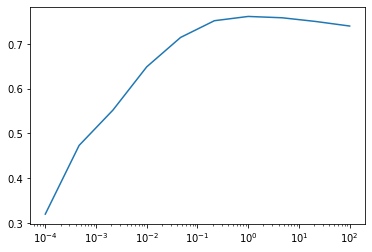

In [25]:
plt.plot(logit_grid_searcher1.Cs_, 
         logit_grid_searcher1.scores_[31].mean(axis=0),
         )
plt.xscale('log')

Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [26]:
logit_mean_cv_scores1 = logit_grid_searcher1.scores_[31].mean(axis=0)

In [36]:
logit_c_values1

array([1.00000000e-04, 4.64158883e-04, 2.15443469e-03, 1.00000000e-02,
       4.64158883e-02, 2.15443469e-01, 1.00000000e+00, 4.64158883e+00,
       2.15443469e+01, 1.00000000e+02])

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [30]:
logit_c_values1[np.argmax(logit_mean_cv_scores1)]

1.0

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

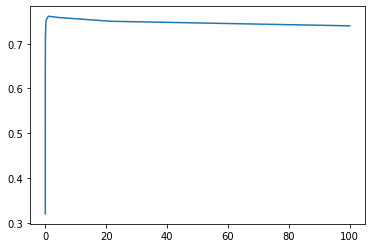

In [31]:
plt.plot(logit_c_values1, logit_mean_cv_scores1);

**Теперь то же самое, только значения параметра `C` перебирайте в диапазоне `np.linspace`(0.1, 7, 20). Опять нарисуйте кривые валидации, определите максимальное значение доли правильных ответов на кросс-валидации.**

In [40]:
%%time
logit_c_values2 = np.linspace(0.1, 7, 20)

logit_grid_searcher2 = LogisticRegressionCV(Cs=logit_c_values2,
                                           multi_class='multinomial',
                                           random_state=17,
                                           cv=skf) 
logit_grid_searcher2.fit(X_train, y_train)

CPU times: user 2min 23s, sys: 3min 4s, total: 5min 28s
Wall time: 1min 36s


LogisticRegressionCV(Cs=array([0.1       , 0.46315789, 0.82631579, 1.18947368, 1.55263158,
       1.91578947, 2.27894737, 2.64210526, 3.00526316, 3.36842105,
       3.73157895, 4.09473684, 4.45789474, 4.82105263, 5.18421053,
       5.54736842, 5.91052632, 6.27368421, 6.63684211, 7.        ]),
                     class_weight=None,
                     cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
                     dual=False, fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=None, max_iter=100, multi_class='multinomial',
                     n_jobs=None, penalty='l2', random_state=17, refit=True,
                     scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [41]:
logit_mean_cv_scores2 = logit_grid_searcher2.scores_[31].mean(axis=0)
logit_grid_searcher2.scores_

{31: array([[0.73483694, 0.75952454, 0.76196282, 0.76043889, 0.76104846,
         0.76074368, 0.75921975, 0.75891496, 0.75891496, 0.75952454,
         0.75830539, 0.75739104, 0.75739104, 0.75525754, 0.75586711,
         0.75556233, 0.75373362, 0.75434319, 0.75342883, 0.75251448],
        [0.72325511, 0.74641877, 0.7479427 , 0.74885706, 0.74977141,
         0.74946663, 0.74824749, 0.74763792, 0.74824749, 0.74641877,
         0.74702835, 0.74672356, 0.74459006, 0.74459006, 0.74398049,
         0.74306614, 0.74123743, 0.74062786, 0.73910393, 0.73849436],
        [0.74634146, 0.77164634, 0.77347561, 0.77256098, 0.77286585,
         0.77469512, 0.7722561 , 0.77164634, 0.77195122, 0.77195122,
         0.7722561 , 0.77164634, 0.77164634, 0.77195122, 0.77134146,
         0.77042683, 0.77042683, 0.77012195, 0.7695122 , 0.76829268]]),
 33: array([[0.73483694, 0.75952454, 0.76196282, 0.76043889, 0.76104846,
         0.76074368, 0.75921975, 0.75891496, 0.75891496, 0.75952454,
         0.75830539, 

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [46]:
c2 = logit_c_values2[np.argmax(logit_mean_cv_scores2)]

In [43]:
logit_c_values2

array([0.1       , 0.46315789, 0.82631579, 1.18947368, 1.55263158,
       1.91578947, 2.27894737, 2.64210526, 3.00526316, 3.36842105,
       3.73157895, 4.09473684, 4.45789474, 4.82105263, 5.18421053,
       5.54736842, 5.91052632, 6.27368421, 6.63684211, 7.        ])

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

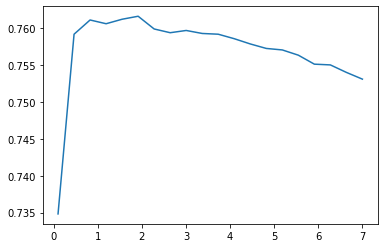

In [44]:
plt.plot(logit_c_values2, logit_mean_cv_scores2);

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для логистической регрессии с лучшим найденным значением `C`.

In [49]:
logit.set_params(C=c2)
logit.fit(X_train, y_train)
logit_cv_acc = accuracy_score(y_valid, logit.predict(X_valid))
logit_cv_acc
# logit

0.7817018250770325

In [50]:
logit_mean_cv_scores2.max()

0.7616351412294983

**<font color='red'>Вопрос 3. </font>Посчитайте доли правильных ответов для `logit_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [52]:
with open('answer4_3.txt', 'w') as f:
    f.write('0.761 0.782')

**4. Обучите линейный SVM (`LinearSVC`) с параметром `C`=1 и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`.**

In [53]:
from sklearn.svm import LinearSVC

In [54]:
svm = LinearSVC(C=1, random_state=17)
cv4 = cross_val_score(svm, X_train, y_train, cv=skf).mean()
svm.fit(X_train, y_train)
val4 = accuracy_score(y_valid, svm.predict(X_valid))
cv4,  val4

(0.7508655711747608, 0.7769613652524295)

**С помощью `GridSearchCV` подберите параметр `C` для SVM сначала в широком диапазоне: 10 значений от 1e-4 до 1e4, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [62]:
%%time
svm_params1 = {'C': np.linspace(1e-4, 1e4, 10)}

svm_grid_searcher1 = GridSearchCV(estimator=svm, param_grid=svm_params1,
                                 cv=skf, return_train_score=True,
                                  n_jobs=-1)
svm_grid_searcher1.fit(X_train, y_train)

CPU times: user 3.88 s, sys: 0 ns, total: 3.88 s
Wall time: 42.9 s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
             error_score=nan,
             estimator=LinearSVC(C=1, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=17, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': array([1.0000000e-04, 1.1111112e+03, 2.2222223e+03, 3.3333334e+03,
       4.4444445e+03, 5.5555556e+03, 6.6666667e+03, 7.7777778e+03,
       8.8888889e+03, 1.0000000e+04])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=0)

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [63]:
svm_grid_searcher1.best_score_, svm_grid_searcher1.best_params_

(0.6868546856376824, {'C': 2222.2223000000004})

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

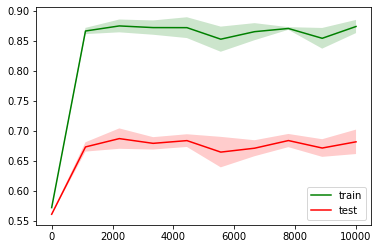

In [65]:
plot_validation_curves(svm_params1['C'], svm_grid_searcher1.cv_results_)

**Но мы помним, что с параметром регуляризации по умолчанию (С=1) на кросс-валидации доля правильных ответов выше. Это тот случай (не редкий), когда можно ошибиться и перебирать параметры не в том диапазоне (причина в том, что мы взяли равномерную сетку на большом интервале и упустили действительно хороший интервал значений `C`). Здесь намного осмысленней подбирать `C` в районе 1, к тому же, так модель быстрее обучается, чем при больших `C`. **

**С помощью `GridSearchCV` подберите параметр `C` для SVM в диапазоне (1e-3, 1), 30 значений, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [66]:
%%time
svm_params2 = {'C': np.linspace(1e-3, 1, 30)}

svm_grid_searcher2 = GridSearchCV(estimator=svm, 
                                  param_grid=svm_params2,
                                 cv=skf, return_train_score=True,
                                  n_jobs=-1)
svm_grid_searcher2.fit(X_train, y_train)

CPU times: user 954 ms, sys: 6.57 ms, total: 960 ms
Wall time: 1min 9s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
             error_score=nan,
             estimator=LinearSVC(C=1, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=17, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': array([0.001     , 0.03544828...
       0.17324138, 0.20768966, 0.24213793, 0.27658621, 0.31103448,
       0.34548276, 0.37993103, 0.41437931, 0.44882759, 0.48327586,
       0.51772414, 0.55217241, 0.58662069, 0.62106897, 0.65551724,
       0.68996552, 0.72441379, 0.75886207, 0.79331034, 0.82775862,
       0.8622069 , 0.89665517, 0.93110345, 0.96555172, 1.        ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=Non

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [123]:
c4 = svm_grid_searcher2.best_params_['C']
svm_grid_searcher2.best_score_
c4

0.10434482758620689

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от С.

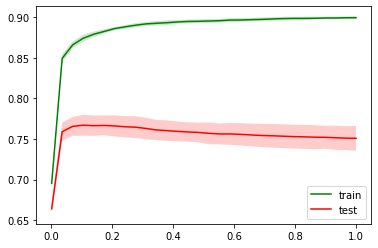

In [68]:
plot_validation_curves(svm_params2['C'], svm_grid_searcher2.cv_results_)

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для `LinearSVC` с лучшим найденным значением `C`.

In [70]:
svm.set_params(C=c4)
svm.fit(X_train, y_train)
svm_cv_acc = accuracy_score(y_valid, svm.predict(X_valid))
svm_cv_acc
# svm
# svm_cv_acc = accuracy_score ''' ВАШ КОД ЗДЕСЬ '''

0.7807537331121118

**<font color='red'>Вопрос 4. </font> Посчитайте доли правильных ответов для `svm_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [74]:
with open('answer4_4.txt', 'w') as f:
    f.write('0.767 0.781')

## Часть 2. Выбор параметров – длины сессии и ширины окна

**Возьмем `LinearSVC`, показавший лучшее качество на кросс-валидации в 1 части, и проверим его работу еще на 8 выборках для 10 пользователей (с разными сочетаниями параметров *session_length* и *window_size*). Поскольку тут уже вычислений побольше, мы не будем каждый раз заново подбирать параметр регуляризации `C`.**

**Определите функцию `model_assessment`, ее документация описана ниже. Обратите внимание на все детали. Например, на то, что разбиение  выборки с `train_test_split` должно быть стратифицированным. Не теряйте нигде `random_state`.**

In [80]:
def model_assessment(estimator, path_to_X_pickle, path_to_y_pickle,
                     cv, random_state=17, test_size=0.3):
    '''
    Estimates CV-accuracy for (1 - test_size) share of (X_sparse, y) 
    loaded from path_to_X_pickle and path_to_y_pickle and holdout accuracy for (test_size) share of (X_sparse, y).
    The split is made with stratified train_test_split with params random_state and test_size.
    
    :param estimator – Scikit-learn estimator (classifier or regressor)
    :param path_to_X_pickle – path to pickled sparse X (instances and their features)
    :param path_to_y_pickle – path to pickled y (responses)
    :param cv – cross-validation as in cross_val_score (use StratifiedKFold here)
    :param random_state –  for train_test_split
    :param test_size –  for train_test_split
    
    :returns mean CV-accuracy for (X_train, y_train) and accuracy for (X_valid, y_valid) where (X_train, y_train)
    and (X_valid, y_valid) are (1 - test_size) and (testsize) shares of (X_sparse, y).
    '''
    with open(path_to_X_pickle, 'rb') as f:
        X_sparse = pickle.load(f)
    with open(path_to_y_pickle, 'rb') as f:
        y = pickle.load(f)
    
    X_train, X_val, y_train, y_val = train_test_split(X_sparse, y,
                                                     test_size=test_size,
                                                     random_state=random_state,
                                                     stratify=y)
#     skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17) 
    cv_score = cross_val_score(estimator, X_train, y_train, cv=cv).mean()
    estimator.fit(X_train, y_train)
    val_           ''' ВАШ КОД ЗДscore = accuracy_score(y_val, estimator.predict(X_val))
    return cv_score, val_score

**Убедитесь, что функция работает.**

In [81]:
model_assessment(svm_grid_searcher2.best_estimator_, 
                 os.path.join(PATH_TO_DATA, 'X_sparse_10users.pkl'),
        os.path.join(PATH_TO_DATA, 'y_10users.pkl'), skf, random_state=17, test_size=0.3)

(0.7670206386611259, 0.7807537331121118)

**Примените функцию *model_assessment* для лучшего алгоритма из предыдущей части (а именно, `svm_grid_searcher2.best_estimator_`) и 9 выборок вида с разными сочетаниями параметров *session_length* и *window_size* для 10 пользователей. Выведите в цикле параметры *session_length* и *window_size*, а также результат вывода функции *model_assessment*. 
Удобно сделать так, чтоб *model_assessment* возвращала 3-им элементом время, за которое она выполнилась. На моем ноуте этот участок кода выполнился за 20 секунд. Но со 150 пользователями каждая итерация занимает уже несколько минут.**

Здесь для удобства стоит создать копии ранее созданных pickle-файлов X_sparse_10users.pkl, X_sparse_150users.pkl, y_10users.pkl и y_150users.pkl, добавив к их названиям s10_w10, что означает длину сессии 10 и ширину окна 10. 

In [82]:
!cp $PATH_TO_DATA/X_sparse_10users.pkl $PATH_TO_DATA/X_sparse_10users_s10_w10.pkl 
!cp $PATH_TO_DATA/X_sparse_150users.pkl $PATH_TO_DATA/X_sparse_150users_s10_w10.pkl 
!cp $PATH_TO_DATA/y_10users.pkl $PATH_TO_DATA/y_10users_s10_w10.pkl 
!cp $PATH_TO_DATA/y_150users.pkl $PATH_TO_DATA/y_150users_s10_w10.pkl 

In [83]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
    if window_size <= session_length:
        path_to_X_pkl = os.path.join(PATH_TO_DATA, f'X_sparse_10users_s{session_length}_w{window_size}.pkl')
        path_to_y_pkl = os.path.join(PATH_TO_DATA, f'y_10users_s{session_length}_w{window_size}.pkl')
        print(session_length, window_size, model_assessment(estimator,
                                                           path_to_X_pkl,
                                                           path_to_y_pkl, skf, random_state=17))

15 10 (0.8243252292702751, 0.8404835269021095)
10 10 (0.7670206386611259, 0.7807537331121118)
15 7 (0.8495024256089474, 0.8543222166915547)
10 7 (0.7983645917156946, 0.8073668491786958)
7 7 (0.754765400423003, 0.7617388418782147)
15 5 (0.8670355547005402, 0.8752963489805595)
10 5 (0.8177520250854086, 0.8245614035087719)
7 5 (0.772939529035208, 0.7853247984826932)
5 5 (0.7254849424351582, 0.7362494073020389)
CPU times: user 34.3 s, sys: 0 ns, total: 34.3 s
Wall time: 34.5 s


In [88]:
# %%time
# estimator = svm_grid_searcher2.best_estimator_

# for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
#     if window_size <= session_length:
#         path_to_X_pkl = os.path.join(PATH_TO_DATA, f'X_sparse_150users_s{session_length}_w{window_size}.pkl')
#         path_to_y_pkl = os.path.join(PATH_TO_DATA, f'y_150users_s{session_length}_w{window_size}.pkl')
#         print(session_length, window_size, model_assessment(estimator,
#                                                            path_to_X_pkl,
#                                                            path_to_y_pkl, skf, random_state=17))

KeyboardInterrupt: 

**<font color='red'>Вопрос 5. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_10users_s15_w5`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [85]:
with open('answer4_5.txt', 'w') as f:
    f.write('0.867 0.875')

**Прокомментируйте полученные результаты. Сравните для 150 пользователей доли правильных ответов на кросс-валидации и оставленной выборке для сочетаний параметров (*session_length, window_size*): (5,5), (7,7) и (10,10). На среднем ноуте это может занять до часа – запаситесь терпением, это Data Science :) **

**Сделайте вывод о том, как качество классификации зависит от длины сессии и ширины окна.**

In [135]:
logit_grid_searcher2.scores_[31].mean(axis=0)
logit_grid_searcher2.Cs_, c2

(array([0.1       , 0.46315789, 0.82631579, 1.18947368, 1.55263158,
        1.91578947, 2.27894737, 2.64210526, 3.00526316, 3.36842105,
        3.73157895, 4.09473684, 4.45789474, 4.82105263, 5.18421053,
        5.54736842, 5.91052632, 6.27368421, 6.63684211, 7.        ]),
 1.9157894736842107)

In [90]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in [(5,5), (7,7), (10,10)]:
    path_to_X_pkl = os.path.join(PATH_TO_DATA, f'X_sparse_150users_s{session_length}_w{window_size}.pkl')
    path_to_y_pkl = os.path.join(PATH_TO_DATA, f'y_150users_s{session_length}_w{window_size}.pkl')
    print(session_length, window_size, model_assessment(estimator,
                                                           path_to_X_pkl,
                                                           path_to_y_pkl, skf, random_state=17))

5 5 (0.4083611011164474, 0.42171606560568453)
7 7 (0.4366487102001489, 0.45295840855673264)
10 10 (0.46307591254574465, 0.4836276942538802)
CPU times: user 27min 26s, sys: 0 ns, total: 27min 26s
Wall time: 27min 41s


**<font color='red'>Вопрос 6. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_150users`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [91]:
with open('answer4_6.txt', 'w') as f:
    f.write('0.463 0.484')

## Часть 3. Идентификация  конкретного пользователя и кривые обучения

**Поскольку может разочаровать, что многоклассовая доля правильных ответов на выборке из 150 пользовалей невелика, порадуемся тому, что конкретного пользователя можно идентифицировать достаточно хорошо. **

**Загрузим сериализованные ранее объекты *X_sparse_150users* и *y_150users*, соответствующие обучающей выборке для 150 пользователей с параметрами (*session_length, window_size*) = (10,10). Так же точно разобьем их на 70% и 30%.**

In [92]:
with open(os.path.join(PATH_TO_DATA, 'X_sparse_150users.pkl'), 'rb') as X_sparse_150users_pkl:
     X_sparse_150users = pickle.load(X_sparse_150users_pkl)
with open(os.path.join(PATH_TO_DATA, 'y_150users.pkl'), 'rb') as y_150users_pkl:
    y_150users = pickle.load(y_150users_pkl)

In [93]:
X_train_150, X_valid_150, y_train_150, y_valid_150 = train_test_split(X_sparse_150users, 
                                                                      y_150users, test_size=0.3, 
                                                     random_state=17, stratify=y_150users)

**Обучите `LogisticRegressionCV` для одного значения параметра `C` (лучшего на кросс-валидации в 1 части, используйте точное значение, не на глаз). Теперь будем решать 150 задач "Один-против-Всех", поэтому укажите аргумент `multi_class`='ovr'. Как всегда, где возможно, указывайте `n_jobs=-1` и `random_state`=17.**

In [176]:
logit_grid_searcher2.Cs_,
logit_grid_searcher2.scores_[31].max()
logit_grid_searcher2.scores_[31]
# 0.76196282, 0.77469512

array([[0.73483694, 0.75952454, 0.76196282, 0.76043889, 0.76104846,
        0.76074368, 0.75921975, 0.75891496, 0.75891496, 0.75952454,
        0.75830539, 0.75739104, 0.75739104, 0.75525754, 0.75586711,
        0.75556233, 0.75373362, 0.75434319, 0.75342883, 0.75251448],
       [0.72325511, 0.74641877, 0.7479427 , 0.74885706, 0.74977141,
        0.74946663, 0.74824749, 0.74763792, 0.74824749, 0.74641877,
        0.74702835, 0.74672356, 0.74459006, 0.74459006, 0.74398049,
        0.74306614, 0.74123743, 0.74062786, 0.73910393, 0.73849436],
       [0.74634146, 0.77164634, 0.77347561, 0.77256098, 0.77286585,
        0.77469512, 0.7722561 , 0.77164634, 0.77195122, 0.77195122,
        0.7722561 , 0.77164634, 0.77164634, 0.77195122, 0.77134146,
        0.77042683, 0.77042683, 0.77012195, 0.7695122 , 0.76829268]])

In [177]:
%%time
logit_cv_150users = LogisticRegressionCV(Cs=[logit_grid_searcher2.Cs_[10]], 
                                         multi_class='ovr',
                                        random_state=17,
                                         cv=skf,
                                        n_jobs=-1)
logit_cv_150users.fit(X_train_150, y_train_150)

CPU times: user 6min 55s, sys: 8min 53s, total: 15min 48s
Wall time: 7min 49s


LogisticRegressionCV(Cs=[3.7315789473684213], class_weight=None,
                     cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
                     dual=False, fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=None, max_iter=100, multi_class='ovr', n_jobs=-1,
                     penalty='l2', random_state=17, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

**Посмотрите на средние доли правильных ответов на кросс-валидации в задаче идентификации каждого пользователя по отдельности.**

In [138]:
cv_scores_by_user = {}
for user_id, scores in logit_cv_150users.scores_.items():
    print('User {}, CV score: {}'.format(user_id, scores.mean()))

User 6, CV score: 0.9960797806345333
User 13, CV score: 0.9963091551718745
User 15, CV score: 0.995256117523172
User 16, CV score: 0.9918467778090561
User 28, CV score: 0.9903558433163387
User 31, CV score: 0.9944011760658097
User 33, CV score: 0.9937651830304547
User 39, CV score: 0.9858830398381867
User 46, CV score: 0.9980398903172666
User 49, CV score: 0.9951935608311699
User 50, CV score: 0.9943281932584739
User 53, CV score: 0.9937130524537862
User 65, CV score: 0.9969451482072295
User 66, CV score: 0.9948077945638234
User 82, CV score: 0.9963717118638766
User 85, CV score: 0.9963717118638766
User 89, CV score: 0.9908771490830232
User 92, CV score: 0.994422028296477
User 100, CV score: 0.9944950111038128
User 102, CV score: 0.9911586541970326
User 103, CV score: 0.9805448687873385
User 105, CV score: 0.9969034437458948
User 106, CV score: 0.9948494990251583
User 118, CV score: 0.9909292796596917
User 119, CV score: 0.9965906602858841
User 120, CV score: 0.994286488797139
User 126

**Результаты кажутся впечатляющими, но возможно, мы забываем про дисбаланс классов, и высокую долю правильных ответов можно получить константным прогнозом. Посчитайте для каждого пользователя разницу между долей правильных ответов на кросс-валидации (только что посчитанную с помощью `LogisticRegressionCV`) и долей меток в *y_train_150*, отличных от ID 
 этого пользователя (именно такую долю правильных ответов можно получить, если классификатор всегда "говорит", что это не пользователь с номером $i$ в задаче классификации $i$-vs-All).**

In [178]:
class_distr = np.bincount(y_train_150.astype('int'))
acc_diff_vs_constant =[]
for user_id in np.unique(y_train_150):
    acc_diff_vs_constant.extend(logit_cv_150users.scores_[user_id].mean() - \
       1 + class_distr[user_id]/y_train_150.shape
                               )
acc_diff_vs_constant = np.array(acc_diff_vs_constant)

In [179]:
num_better_than_default = (acc_diff_vs_constant > 0).sum()
num_better_than_default/acc_diff_vs_constant.shape

array([0.81333333])

**<font color='red'>Вопрос 7. </font> Посчитайте долю пользователей, для которых логистическая регрессия на кросс-валидации дает прогноз лучше константного. Округлите до 3 знаков после запятой.**

In [180]:
with open('answer4_7.txt', 'w') as f:
    f.write('0.813')

**Дальше будем строить кривые обучения для конкретного пользователя, допустим, для 128-го. Составьте новый бинарный вектор на основе *y_150users*, его значения будут 1 или 0 в зависимости от того, равен ли ID-шник пользователя 128.**

In [155]:
y_binary_128 = (y_train_150==128).astype('int')

In [156]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(val_train, val_test, train_sizes, 
                        xlabel='Training Set Size', ylabel='score'):
    def plot_with_err(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
    plot_with_err(train_sizes, val_train, label='train')
    plot_with_err(train_sizes, val_test, label='valid')
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(loc='lower right');

**Посчитайте доли правильных ответов на кросс-валидации в задаче классификации "user128-vs-All" в зависимости от размера выборки. Не помешает посмотреть встроенную документацию для *learning_curve*.**

In [158]:
X_train_150.shape, y_train_150.shape

((95913, 27797), (95913,))

In [159]:
%%time
train_sizes = np.linspace(0.25, 1, 20)
estimator = svm_grid_searcher2.best_estimator_
n_train, val_train, val_test = learning_curve(logit_cv_150users,
                                             X_train_150, y_binary_128,
                                             train_sizes=train_sizes, cv=skf)

CPU times: user 1min 34s, sys: 2min 4s, total: 3min 38s
Wall time: 2min 56s


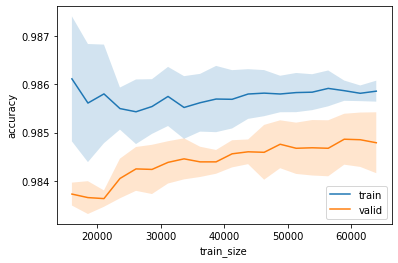

In [160]:
plot_learning_curve(val_train, val_test, n_train, 
                    xlabel='train_size', ylabel='accuracy')

**Сделайте выводы о том, помогут ли алгоритму новые размеченные данные при той же постановке задачи.**

## Пути улучшения
- конечно, можно проверить еще кучу алгоритмов, например, Xgboost, но в такой задаче очень маловероятно, что что-то справится лучше линейных методов
- интересно проверить качество алгоритма на данных, где сессии выделялись не по количеству посещенных сайтов, а по времени, например, 5, 7, 10 и 15 минут. Отдельно стоит отметить данные нашего [соревнования](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) 
- опять же, если ресурсы позволяют, можно проверить, насколько хорошо можно решить задачу для 3000 пользователей


На следующей неделе мы вспомним про линейные модели, обучаемые стохастическим градиентным спуском, и порадуемся тому, насколько быстрее они работают. Также сделаем первые (или не первые) посылки в [соревновании](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) Kaggle Inclass.